## Install Turicreate library

In [2]:
import sys

#!{sys.executable} -m pip install -U  turicreate

# Data Wrangling

## Load the datasets ( Transactions, Items, Users)

In [3]:
import pandas as pd
import os

DATA_DIR = "./data/"
OUTPUT_DIR = "./output/"
MODELS_DIR = "./models/"
transactions_filename = "events_final.csv"
items_filename = "items_final.csv"
customer_filename = "users_final.csv"

item_column_name = "itemid"
user_column_name = "visitorid"
rating_column_name = "event"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

df = pd.read_csv(DATA_DIR+transactions_filename)
df_p = pd.read_csv(DATA_DIR+items_filename)
df_c = pd.read_csv(DATA_DIR+customer_filename)

In [4]:
print(df.shape)
print(df_p.shape)
print(df_c.shape)

(2756101, 6)
(417053, 2)
(1407580, 2)


In [5]:
df.head(1)

,visitorid,event,itemid,month,weekday,period
0,257597,view,355908,6,1,Early Morning


In [6]:
df.tail(1)

,visitorid,event,itemid,month,weekday,period
2756100,199536,view,152913,8,5,Late Night


### See some row samples from the dataframes

In [7]:
df.iloc[0]

visitorid           257597
event                 view
itemid              355908
month                    6
weekday                  1
period       Early Morning
Name: 0, dtype: object

In [8]:
df_p.query(item_column_name + ' == ' + '"'+ str(df.iloc[0][item_column_name]) + '"')

,itemid,categoryid
131954,355908,1173


In [9]:
df_c.query(user_column_name + ' == ' + '"'+ str(df.iloc[0][user_column_name]) + '"')

,visitorid,state
0,257597,Wisconsin


## Transactions Unique values

In [10]:
df.nunique(axis=0)

visitorid    1407580
event              3
itemid        235061
month              5
weekday            7
period             6
dtype: int64

In [11]:
df.period.unique()

array(['Early Morning', 'Night', 'Late Night', 'Evening', 'Noon',
       'Morning'], dtype=object)

## Popularity -> Transactions: Sum of unique values

In [12]:
df_popularity = df.groupby(item_column_name)[item_column_name].count().sort_values('index',ascending=False)

In [13]:
df_popularity.head(5)

itemid
187946    3412
461686    2978
5411      2334
370653    1854
219512    1800
Name: itemid, dtype: int64

## Most Active Customers user_ids

In [14]:
df_c_popularity = df.groupby(user_column_name)[user_column_name].count().sort_values('index',ascending=False)

In [15]:
df_c_popularity

visitorid
1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
           ... 
859354        1
859352        1
859351        1
859350        1
703789        1
Name: visitorid, Length: 1407580, dtype: int64

## Check NaN values

In [16]:
print("Number of rows", df.shape[0])
df.apply(lambda x: sum(x.isnull()))

Number of rows 2756101


visitorid    0
event        0
itemid       0
month        0
weekday      0
period       0
dtype: int64

In [17]:
print("Number of rows", df_c.shape[0])
df_c.apply(lambda x: sum(x.isnull()))

Number of rows 1407580


visitorid    0
state        0
dtype: int64

In [18]:
print("Number of rows", df_p.shape[0])
df_p.apply(lambda x: sum(x.isnull()))

Number of rows 417053


itemid        0
categoryid    0
dtype: int64

In [19]:
# Remove NaNs
import numpy as np

df_p = df_p.replace({np.nan: None})
df_c = df_c.replace({np.nan: None})

df_c = df_c.dropna()
df_p = df_p.dropna()

In [20]:
df_p.nunique(axis=0)

itemid        417053
categoryid      1218
dtype: int64

## Suggested pre-processing techniques
Lastly, here are a couple of common data issues that can affect the performance of a recommender. First, if the observation data is very sparse, i.e., contains only one or two observations for a large number of users, then none of the models will perform much better than the simple baselines available via the popularity_recommender. In this case, it might help to prune out the rare users and rare items and try again. Also, re-examine the data collection and data cleaning process to see if mistakes were made. Try to get more observation data per user and per item, if you can.

Another issue often occurs when usage data is treated as ratings. Unlike explicit ratings that lie on a nice linear interval, say 0 to 5, usage data can be badly skewed. For instance, in the Million Song dataset, one user played a song more than 16,000 times. All the models would have a difficult time fitting to such a badly skewed target. The fix is to bucketize the usage data. For instance, any play count greater than 50 can be mapped to the maximum rating of 5. You can also clip the play counts to be binary, e.g., any number greater than 2 is mapped to 1, otherwise it's 0.

In [21]:
# Remove Rare customers and rare items in the transactions df

desired_users_quantile = 0.8
desired_items_quantile = 0.5

df1 = df.groupby(user_column_name).agg(count=(user_column_name, 'count')).sort_values('count',ascending=False)
df2 = df.groupby(item_column_name).agg(count=(item_column_name, 'count')).sort_values('count',ascending=False)

print("The",desired_users_quantile ,"quantile of number of transactions per customer is: ",df1['count'].quantile(desired_users_quantile)," transactions")
print("The number of rows before removing rare customers is:",len(df1))
df1 = df1[df1['count'] >= df1['count'].quantile(desired_users_quantile)]
print("The number of rows after removing rare customers is:",len(df1))

print("\nThe",desired_items_quantile ,"quantile of number of transactions per item is: ",df2['count'].quantile(desired_items_quantile)," transactions")
print("The number of rows before removing rare items is:",len(df2))
df2 = df2[df2['count'] >= df2['count'].quantile(desired_items_quantile)]
print("The number of rows after removing rare items is:",len(df2))


The 0.8 quantile of number of transactions per customer is:  2.0  transactions
The number of rows before removing rare customers is: 1407580
The number of rows after removing rare customers is: 406020

The 0.5 quantile of number of transactions per item is:  3.0  transactions
The number of rows before removing rare items is: 235061
The number of rows after removing rare items is: 126623


In [22]:
print("\nNumber of transactions before removing rare customers",len(df))
dft = pd.merge(df, df1, on=[user_column_name], how='inner')
print("Number of transactions after removing rare customers",len(dft))

print("\nNumber of transactions before removing rare items",len(dft))
df_final = pd.merge(dft, df2, on=[item_column_name], how='inner')
print("Number of transactions after removing rare items",len(df_final))


Number of transactions before removing rare customers 2756101
Number of transactions after removing rare customers 1754541

Number of transactions before removing rare items 1754541
Number of transactions after removing rare items 1692710


In [23]:
df_final = df_final.drop(['count_x','count_y'], axis=1)
df_final

,visitorid,event,itemid,month,weekday,period
0,257597,view,355908,6,1,Early Morning
1,981382,view,355908,6,0,Night
2,1102250,view,355908,5,1,Early Morning
3,62710,view,355908,7,4,Night
4,76757,view,355908,5,1,Evening
...,...,...,...,...,...,...
1692705,1055379,view,209407,7,4,Evening
1692706,636042,view,221227,8,5,Late Night
1692707,636042,view,221227,8,5,Late Night
1692708,719085,view,414275,7,4,Night


In [24]:
print("Number of rows", df_final.shape[0])
df_final.apply(lambda x: sum(x.isnull()))

Number of rows 1692710


visitorid    0
event        0
itemid       0
month        0
weekday      0
period       0
dtype: int64

## Drop Duplicate transactions to balance dataset better

In [25]:
df_balanced = df_final.drop_duplicates()
print(df_final.shape)
print(df_balanced.shape)

(1692710, 6)
(1327002, 6)


In [26]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)

df_bal_pop = df_balanced.groupby(item_column_name).agg(count=(item_column_name, 'count')).sort_values('count',ascending=False)

pd.merge(df_bal_pop, df_p, on=[item_column_name], how='left').head(20)

,itemid,count,categoryid
0,461686,1724,1037.0
1,257040,1091,683.0
2,219512,1049,5.0
3,309778,988,683.0
4,384302,969,5.0
5,320130,886,1483.0
6,234255,825,1051.0
7,190000,758,5.0
8,312728,753,1098.0
9,111530,749,1625.0


In [27]:
df_bal_pop.drop(df_bal_pop.head(50).index)

,count
itemid,
179601,455
339703,449
12217,442
354233,442
315545,442
...,...
326048,1
97499,1
326059,1


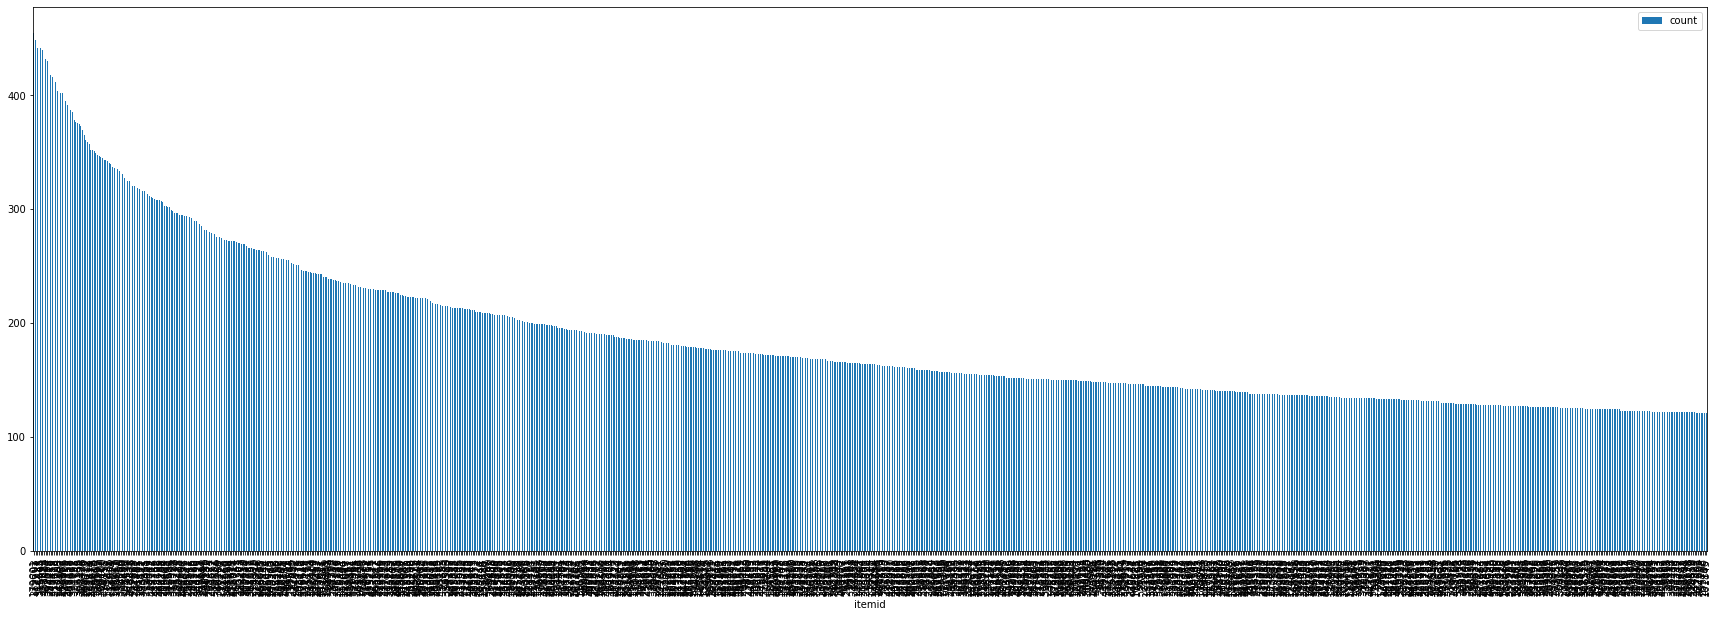

In [28]:
# Plot the distribution of top 1000 popular items that are NOT the top 50
df_bal_pop.drop(df_bal_pop.head(50).index).head(1000).plot.bar()

## Check datasets before modeling

In [29]:
print("Number of rows", df_balanced.shape[0])
df_balanced.apply(lambda x: sum(x.isnull()))

Number of rows 1327002


visitorid    0
event        0
itemid       0
month        0
weekday      0
period       0
dtype: int64

In [30]:
df_balanced[df_balanced.isna().any(axis=1)]

,visitorid,event,itemid,month,weekday,period


In [31]:
print("Number of rows", df_c.shape[0])
df_c.apply(lambda x: sum(x.isnull()))

Number of rows 1407580


visitorid    0
state        0
dtype: int64

In [32]:
print("Number of rows", df_p.shape[0])
df_p.apply(lambda x: sum(x.isnull()))

Number of rows 417053


itemid        0
categoryid    0
dtype: int64

# Modeling

## Create the SFrames that Turicreate needs for the recomender

In [33]:
import turicreate
from turicreate import SFrame

In [34]:
sf = SFrame(data=df_balanced)

In [35]:
sf.show()

Materializing SFrame

In [36]:
sf_p = SFrame(data=df_p)

In [37]:
sf_p

itemid,categoryid
460429,1338
35575,1059
397079,619
380850,691
13810,1421
158304,1069
378565,1007
442915,89
280545,173
285066,184


In [38]:
sf_c = SFrame(data=df_c)

In [39]:
sf_c.show()

Materializing SFrame

## Spliting Dataset in Training and Testing

In [40]:
df_c_popularity[df_c_popularity < df_c_popularity.quantile(0.80)].index

Int64Index([474962, 431177, 104594, 475192, 100337, 431456, 431454, 100422,
            100314, 100333,
            ...
            859363, 859360, 859359, 859357, 859356, 859354, 859352, 859351,
            859350, 703789],
           dtype='int64', name='visitorid', length=1001560)

In [41]:
df_balanced[user_column_name]

0           257597
1           981382
2          1102250
3            62710
4            76757
            ...   
1692703     409139
1692704    1055379
1692706     636042
1692708     719085
1692709     331947
Name: visitorid, Length: 1327002, dtype: int64

In [42]:
high_rated_data = SFrame(data=df_balanced[df_balanced[user_column_name].isin(df_c_popularity[df_c_popularity >= df_c_popularity.quantile(0.98)].index.tolist())])

low_rated_data = SFrame(data=df_balanced[df_balanced[user_column_name].isin(df_c_popularity[df_c_popularity < df_c_popularity.quantile(0.98)].index.tolist())])
train_data_1, test_sf = turicreate.recommender.util.random_split_by_user(high_rated_data, 
                                                                     user_id=user_column_name, 
                                                                     item_id=item_column_name)

train_sf = train_data_1.append(low_rated_data)

## Train models

### MODEL 1 - Build a Item Similarity model using only Transaction data

In [43]:
model_s = turicreate.recommender.item_similarity_recommender.create(observation_data = train_sf,
                                                                    user_id=user_column_name, 
                                                                    item_id=item_column_name)

Warning: Ignoring columns event, month, weekday, period;

To use one of these as a rating column, specify the column name to be used as target

and use a method that allows the use of a target.

Preparing data set.

Data has 1324380 observations with 400279 users and 116212 items.

Data prepared in: 0.83522s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.172ms                        | 0          |

| 70.228ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in 7 passes using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.59s                               | 0                | 0               |

| 16.46s                              | 14.25            | 16599           |

| 28.93s                              | 28.5             | 33199           |

| 41.34s                              | 42.75            | 49798           |

| 53.50s                              | 57               | 66398           |

| 1m 5s                               | 71.25            | 82997           |

| 1m 15s                              | 85.5             | 99597           |

| 1m 16s                              | 100              | 116212          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 77.7597s

### MODEL 2 - Build a Ranking factorization model using item and user side features

In [44]:
model_f = turicreate.ranking_factorization_recommender.create(observation_data = train_sf,
                                                              user_id=user_column_name, 
                                                              item_id=item_column_name,
                                                              user_data=sf_c,
                                                              item_data=sf_p
                                                             )

Preparing data set.

Data has 1324380 observations with 1407580 users and 432395 items.

Data prepared in: 2.05041s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| binary_target                  | Assume Binary Targets                            | True     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 165547 / 1324380 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 6.25              | Not Viable                               |

| 1       | 1.5625            | Not Viable                               |

| 2       | 0.390625          | Not Viable                               |

| 3       | 0.0976562         | Not Viable                               |

| 4       | 0.0244141         | No Decrease (4.83375 >= 1.38645)         |

| 5       | 0.00610352        | No Decrease (1.47647 >= 1.38645)         |

| 6       | 0.00152588        | No Decrease (1.3986 >= 1.38645)          |

| 7       | 0.00038147        | 1.38475                                  |

| 8       | 0.000190735       | 1.38604                                  |

| 9       | 9.53674e-05       | 1.38604                                  |

| 10      | 4.76837e-05       | 1.38617                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00038147        | 1.38475                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training Predictive Error | Step Size   |

+---------+--------------+-------------------+-----------------------------------+-------------+

| Initial | 102us        | 1.38645           | 0.693027                          |             |

+---------+--------------+-------------------+-----------------------------------+-------------+

| 1       | 4.54s        | 1.38487           | 0.687817                          | 0.00038147  |

| 2       | 8.98s        | 1.38408           | 0.684063                          | 0.00038147  |

| 3       | 13.39s       | 1.38285           | 0.684946                          | 0.00038147  |

| 4       | 17.80s       | 1.38307           | 0.685152                          | 0.00038147  |

| 5       | 22.27s       | 1.38221           | 0.68882                           | 0.00038147  |

| 7       | 31.09s       | 1.3845            | 0.691981                          | 0.00038147  |

| 8       | 35.52s       | 1.38723           | 0.692235                          | 0.00038147  |

| 9       | 39.82s       | 1.38822           | 0.695439                          | 0.00038147  |

| 10      | 44.17s       | 1.39189           | 0.695929                          | 0.00038147  |

| 11      | 48.46s       | 1.3934            | 0.698833                          | 0.00038147  |

| 12      | 52.78s       | 1.39618           | 0.699903                          | 0.00038147  |

| 13      | 58.65s       | DIVERGED          | DIVERGED                          | 0.00038147  |

| RESET   | 1m 1s        | 1.38645           | 0.693375                          |             |

| 1       | 1m 5s        | 1.38542           | 0.690654                          | 0.000190735 |

| 2       | 1m 10s       | 1.38528           | 0.687861                          | 0.000190735 |

| 3       | 1m 14s       | 1.3852            | 0.686355                          | 0.000190735 |

| 4       | 1m 18s       | 1.38496           | 0.685393                          | 0.000190735 |

| 5       | 1m 23s       | 1.38458           | 0.684785                          | 0.000190735 |

| 6       | 1m 27s       | 1.3842            | 0.684417                          | 0.000190735 |

| 7       | 1m 31s       | 1.38377           | 0.684351                          | 0.000190735 |

| 8       | 1m 36s       | 1.3832            | 0.684557                          | 0.000190735 |

| 9       | 1m 40s       | 1.38294           | 0.684613                          | 0.000190735 |

| 10      | 1m 44s       | 1.38267           | 0.684712                          | 0.000190735 |

| 11      | 1m 49s       | 1.38226           | 0.685235                          | 0.000190735 |

| 12      | 1m 53s       | 1.38213           | 0.685492                          | 0.000190735 |

| 13      | 1m 57s       | 1.38194           | 0.685906                          | 0.000190735 |

| 14      | 2m 2s        | 1.3818            | 0.686362                          | 0.000190735 |

| 15      | 2m 6s        | 1.38177           | 0.686648                          | 0.000190735 |

| 16      | 2m 10s       | 1.382             | 0.686792                          | 0.000190735 |

| 17      | 2m 15s       | 1.38204           | 0.687289                          | 0.000190735 |

+---------+--------------+-------------------+-----------------------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training Predictive Error.

Final objective value: 1.38203

Final training Predictive Error: 0.68739

## Evaluation and model comparison
When trying out different recommender models, it's critical to have a principled way of evaluating their performance. The standard approach to this is to split the observation data into two parts, a training set and a test set. The model is trained on the training set, and then evaluated on the test set -- evaluating your model on the same dataset that it was trained on gives a very bad idea of how well it will perform in practice. Once the model type and associated parameters are chosen, the model can be trained on the full dataset.

With recommender systems, we can evaluate models using two different metrics, RMSE and precision-recall. RMSE measures how well the model predicts the score of the user, while precision-recall measures how well the recommend() function recommends items that the user also chooses. For example, the best RMSE value is when the model exactly predicts the value of all the ratings in the test set. Similarly, the best precision-recall value is when the user has 5 items in the test set and recommend() recommends exactly those 5 items. While both can be important depending on the type of data and desired task, precision-recall is often more useful in evaluating how well a recommender system will perform in practice.

In [45]:
eval_list = turicreate.recommender.util.compare_models(test_sf, [model_s, model_f], 
                                                       model_names=["Similarity", "Factorization"], 
                                                       metric='precision_recall',   
                                                       verbose=False)

In [46]:
# Similarity model mean precision and recall
eval_list[0]['precision_recall_overall'].to_dataframe().head(10).mean()

cutoff       5.500000
precision    0.046913
recall       0.098666
dtype: float64

In [47]:
# Factorization model mean precision and recall
eval_list[1]['precision_recall_overall'].to_dataframe().head(10).mean()

cutoff       5.500000
precision    0.002426
recall       0.003854
dtype: float64

</br>
It looks like the Similarity model is better on the test set than the factorization model

 - Items similarity model recomended 12% of the items found in the test set
 - Factorization model recommended 8% of the items found on the tesst set
 
This doesn't necesarily mean that the model_s recommendations are "better", but it is the best evaluation metric that we can have right now.

The real test would be to deploy both models and do AB testing live and see how rentals perform
</br>
</br>

## Save the models to disk

In [48]:
model_s.save(MODELS_DIR + "recommendation_s.model")
model_s = turicreate.load_model(MODELS_DIR + "recommendation_s.model")

In [49]:
model_f.save(MODELS_DIR + "recommendation_f.model")
model_f = turicreate.load_model(MODELS_DIR + "recommendation_f.model")

# Sample queries to the models
By default, recommend() excludes items seen during training, so that it would not recommend items that the user has already seen. To change this behavior, you can specify exclude_known=False

## Query the model for recommendations on specific user(s)
By default, recommend() excludes items seen during training, so that it would not recommend items that the user has already rented. To change this behavior, you can specify exclude_known=False

In [50]:
uid = 163561
pd.merge(model_s.recommend(users=[uid], k=20).to_dataframe().head(10), df_p, on=[item_column_name], how='left')

,visitorid,itemid,score,rank,categoryid
0,163561,400442,0.007322,1,396
1,163561,1644,0.005910,2,396
2,163561,462394,0.005506,3,808
3,163561,116022,0.005490,4,895
4,163561,425920,0.004993,5,1496
5,163561,437778,0.004863,6,808
6,163561,366177,0.004689,7,808
7,163561,377449,0.004647,8,1113
8,163561,89323,0.004407,9,793
9,163561,174724,0.004258,10,936


In [51]:
pd.merge(model_f.recommend(users=[uid], k=10).to_dataframe(), df_p, on=[item_column_name], how='left')

,visitorid,itemid,score,rank,categoryid
0,163561,461686,0.528885,1,1037
1,163561,320130,0.521917,2,1483
2,163561,257040,0.519921,3,683
3,163561,219512,0.519631,4,5
4,163561,234255,0.519185,5,1051
5,163561,111530,0.519164,6,1625
6,163561,37029,0.519135,7,1483
7,163561,187946,0.519130,8,1393
8,163561,384302,0.518874,9,5
9,163561,309778,0.517930,10,683


## If we want a recomendation for specific user but excluding the top 50 popular items

In [53]:
exclude_df = pd.DataFrame().assign(itemid=df_bal_pop.reset_index()[item_column_name].head(50), visitorid=uid)
exclude_items = turicreate.SFrame(data=exclude_df)

model_s.recommend(users=[6000], k=20, exclude = exclude_items).print_rows(20)
model_f.recommend(users=[6000], k=20, exclude = exclude_items).print_rows(20)

+-----------+--------+----------------------+------+
| visitorid | itemid |        score         | rank |
+-----------+--------+----------------------+------+
|    6000   | 64700  | 0.059895833333333336 |  1   |
|    6000   | 158457 | 0.05555556217829386  |  2   |
|    6000   | 50575  |  0.0476190447807312  |  3   |
|    6000   | 342866 |  0.0476190447807312  |  4   |
|    6000   | 393111 |  0.0476190447807312  |  5   |
|    6000   | 54572  |  0.0476190447807312  |  6   |
|    6000   | 464114 |  0.0476190447807312  |  7   |
|    6000   | 342139 | 0.041666666666666664 |  8   |
|    6000   | 279324 | 0.041666666666666664 |  9   |
|    6000   | 26634  | 0.038888891537984215 |  10  |
|    6000   | 310944 | 0.038727521896362305 |  11  |
|    6000   | 19273  |  0.0370370348294576  |  12  |
|    6000   | 152813 | 0.030303021272023518 |  13  |
|    6000   | 442932 | 0.02777777115503947  |  14  |
|    6000   | 148830 | 0.023809532324473064 |  15  |
|    6000   | 429527 | 0.023809532324473064 | 

## Making recommendations for new users
This is known as the "cold-start" problem.</br>
This is where Factorization algorithm really shines, since it can use the side and observation data in order to give better cold-start results.</br>
The recommend() function works seamlessly with new users. If the model has never seen the user, then it defaults to recommending popular items. To improve recommendations for new users, it helps to have side information or new observation data for the user.

In [54]:
# User 700000000 doesn't exist in data set
# Let's assume that this user 700000000 comes in on month 2, weekday 4, and period 5

uids = [700000000]
n_rec = 10

users_query = turicreate.SFrame({user_column_name: uids, 'month': [2], 'weekday': [4], 'period': [5]})

pd.merge(model_f.recommend(users=users_query, k=n_rec).to_dataframe(), df_p, on=[item_column_name], how='left')

,visitorid,itemid,score,rank,categoryid
0,700000000,369447,0.508143,1,48
1,700000000,405649,0.491541,2,50
2,700000000,191581,0.491283,3,596
3,700000000,444899,0.490741,4,175
4,700000000,346673,0.490498,5,72
5,700000000,129717,0.489584,6,224
6,700000000,94468,0.488897,7,35
7,700000000,465470,0.488584,8,65
8,700000000,10162,0.488262,9,48
9,700000000,129191,0.488166,10,491


In [55]:
# Now let's change the Analysis Grouping to General Tool

users_query = turicreate.SFrame({user_column_name: uids, 'month': [5], 'weekday': [4], 'period': [5]})

pd.merge(model_f.recommend(users=users_query, k=n_rec).to_dataframe(), df_p, on=[item_column_name], how='left')

,visitorid,itemid,score,rank,categoryid
0,700000000,369447,0.508143,1,48
1,700000000,405649,0.491541,2,50
2,700000000,191581,0.491283,3,596
3,700000000,444899,0.490741,4,175
4,700000000,346673,0.490498,5,72
5,700000000,129717,0.489584,6,224
6,700000000,94468,0.488897,7,35
7,700000000,465470,0.488584,8,65
8,700000000,10162,0.488262,9,48
9,700000000,129191,0.488166,10,491


In [75]:
# Now let's change the Analysis Grouping to FLOORING SOLUTIONS

users_query = turicreate.SFrame({user_column_name: uids, 'event': ['purchased'], 'month': [2], 'weekday': [1], 'period': [1]})

pd.merge(model_f.recommend(users=users_query, k=n_rec).to_dataframe(), df_p, on=[item_column_name], how='left')

,visitorid,itemid,score,rank,categoryid
0,700000000,129717,0.670313,1,224
1,700000000,87268,0.668194,2,126
2,700000000,292244,0.668126,3,224
3,700000000,444899,0.668055,4,175
4,700000000,405649,0.667965,5,50
5,700000000,412143,0.666818,6,126
6,700000000,118557,0.666702,7,196
7,700000000,331500,0.666042,8,126
8,700000000,94468,0.665889,9,35
9,700000000,465470,0.665733,10,65


#### As we can see above, the observation data is really important for the recomendation of unknown users

## Finding Similar Items
Querying for similar items can help you understand the model's behavior on your data.</br>
This can be also used to recommend **"Users who rent this item normally rent these as well"**

In [77]:
my_list_of_items = [331500] 
pd.merge(model_s.get_similar_items(my_list_of_items, k=10).to_dataframe(), df_p, how='left', left_on=['similar'],right_on=[item_column_name])

,itemid_x,similar,score,rank,itemid_y,categoryid
0,331500,399256,0.166667,1,399256,1421
1,331500,423841,0.166667,2,423841,680
2,331500,233169,0.142857,3,233169,244
3,331500,329943,0.142857,4,329943,126
4,331500,450940,0.142857,5,450940,126
5,331500,257538,0.142857,6,257538,680
6,331500,210639,0.142857,7,210639,558
7,331500,124195,0.125000,8,124195,219
8,331500,265802,0.111111,9,265802,360
9,331500,196404,0.111111,10,196404,1645


In [78]:
my_list_of_items = [196404]
pd.merge(model_f.get_similar_items(my_list_of_items, k=10).to_dataframe(), df_p, how='left', left_on=['similar'],right_on=[item_column_name])

,itemid_x,similar,score,rank,itemid_y,categoryid
0,196404,127122,0.999879,1,127122,1375
1,196404,439851,0.999867,2,439851,1320
2,196404,174419,0.999855,3,174419,1680
3,196404,240535,0.999851,4,240535,1639
4,196404,245032,0.999846,5,245032,1277
5,196404,142391,0.999843,6,142391,1076
6,196404,256392,0.999842,7,256392,1374
7,196404,303620,0.999840,8,303620,1511
8,196404,185179,0.999837,9,185179,1317
9,196404,350555,0.999837,10,350555,1374


# Useful Functions

In [82]:
def create_output(model, users_to_recommend, n_rec):
    recomendation = model.recommend(users=users_to_recommend, k=n_rec)
    df_rec = recomendation.to_dataframe()
    df_rec['recommendedProducts'] = df_rec.groupby([user_column_name])[item_column_name] \
        .transform(lambda x: ' | '.join(x.astype(str)))
    df_output = df_rec[[user_column_name, 'recommendedProducts']].drop_duplicates() \
        .sort_values(user_column_name).set_index(user_column_name)
    return df_output

def customer_recomendation(customer_id, df_output):
    if customer_id not in df_output.index:
        print('Customer not found.')
        return customer_id
    return df_output.query(user_column_name + ' == '+ str(customer_id))

In [83]:
pd.options.display.max_colwidth = 300
create_output(model_s,[6000,56798,4], 15)  #Item Similarity Model

,recommendedProducts
visitorid,
4,456056 | 119736 | 338395 | 439963 | 186702 | 213834 | 62275 | 89323 | 334401 | 146613 | 38965 | 428648 | 301721 | 369158 | 71733
6000,64700 | 158457 | 393111 | 54572 | 50575 | 464114 | 342866 | 279324 | 342139 | 26634 | 310944 | 19273 | 152813 | 442932 | 148830
56798,456056 | 119736 | 338395 | 439963 | 186702 | 213834 | 62275 | 89323 | 334401 | 146613 | 38965 | 428648 | 301721 | 369158 | 71733


In [84]:
pd.options.display.max_colwidth = 300
create_output(model_f,[6000,56798,4], 15)  #Factorization Model

,recommendedProducts
visitorid,
4,461686 | 257040 | 320130 | 309778 | 219512 | 234255 | 111530 | 37029 | 384302 | 312728 | 187946 | 29196 | 9877 | 445351 | 455183
6000,461686 | 257040 | 320130 | 309778 | 219512 | 234255 | 111530 | 37029 | 384302 | 312728 | 187946 | 29196 | 9877 | 445351 | 455183
56798,461686 | 257040 | 320130 | 309778 | 219512 | 234255 | 111530 | 37029 | 384302 | 312728 | 187946 | 29196 | 9877 | 445351 | 455183


In [1]:
customer_recomendation(6000,df_rec_f)

NameError: name 'customer_recomendation' is not defined

# Reference Links and Reads

https://apple.github.io/turicreate/docs/userguide/recommender/

https://apple.github.io/turicreate/docs/api/turicreate.toolkits.recommender.html

https://medium.datadriveninvestor.com/how-to-build-a-recommendation-system-for-purchase-data-step-by-step-d6d7a78800b6

